In [373]:
# Imports
import numpy as np
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal import hann, butter, filtfilt, lfilter
from scipy import signal
import matplotlib.pyplot as plt

In [374]:
# Parameter
N_FFT = 1024        # Number of measuring points 
FS = 14000          # Sampling frequency
wFS = FS*2*np.pi    # circular sampling frequency
DT = 1/FS           # Time per sample
TS = DT*N_FFT       # Sampling time

print(DT,TS)

7.142857142857143e-05 0.07314285714285715


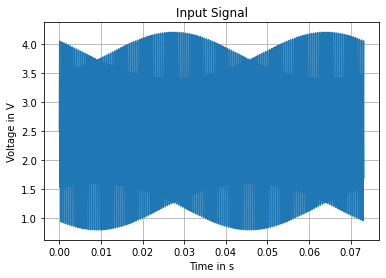

In [375]:

# demo signal
t = np.linspace(0,TS,N_FFT) # time vector

# main Signal
f1 = 4000                   # Frequency for the demo signal
w1 = 2*np.pi*f1             # circular frequency
A1 = 1.500                  # Amplitude
DC = 2.5                    # DC value
s1 = A1*np.sin(w1*t) + DC   # Build the signal

# noise 1
# 10kHz
fn1 = 20000                 # Frequency of the noise
wn1 = 2*np.pi*fn1           # circular frequency
An1 = 0.100                 # Amplitude
sn1 = An1*np.sin(wn1*t)     # Build the signal

# noise 2
# 50Hz
fn2 = 50
wn2 = 2*np.pi*fn1
An2 = 0.100
sn2 = An2*np.sin(wn2*t)

# Signal
y = s1 + sn1 + sn2 # Signal

# Plot of the Signal
plt.plot(t,y)
plt.grid()
plt.title("Input Signal")
plt.xlabel("Time in s")
plt.ylabel("Voltage in V")
plt.show()

2.500722419931737


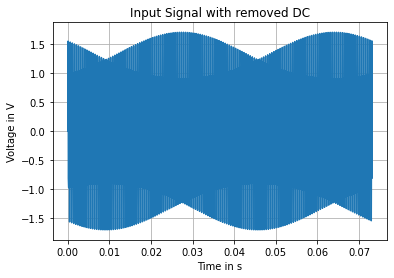

In [376]:
# Calculate DC
DC = 1/N_FFT * np.sum(y)
print(DC)

# remove DC
y = y-DC
plt.plot(t,y)
plt.grid()
plt.title("Input Signal with removed DC")
plt.xlabel("Time in s")
plt.ylabel("Voltage in V")
plt.show()

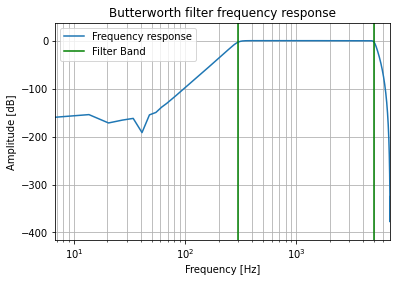

In [377]:
# create the filter
b,a = butter(10, np.multiply([300, 5000], 2*np.pi), btype="band", fs=(FS*2*np.pi), output='ba', analog=False)
w,h = signal.freqz(b,a, worN=N_FFT,fs=wFS)
plt.semilogx(w/(2*np.pi),20*np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.margins(0, 0.1)
plt.axvline(300, color='green') # highpass frequency
plt.axvline(5000, color='green') # lowpass frequency
plt.legend(["Frequency response","Filter Band"])
plt.show()

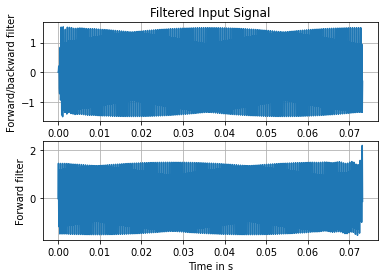

In [378]:
# filter the signal with filtfilt
y_filt2 = filtfilt(b,a,y)

# filter the signal with lfilter
y_filt = lfilter(b,a,y)

# plot the filtered signals
plt.subplot(211)
plt.plot(t,y_filt)
plt.title("Filtered Input Signal")
plt.ylabel("Forward/backward filter")
plt.grid()

plt.subplot(212)
plt.plot(t,y_filt2)
plt.xlabel("Time in s")
plt.ylabel("Forward filter")
plt.grid()
plt.show()


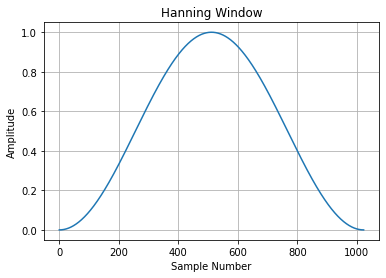

In [379]:
#create a Window
window = hann(N_FFT, sym=True)
plt.plot(window)
plt.title("Hanning Window")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.grid()
plt.show()



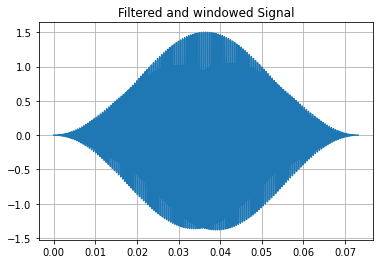

In [380]:
# apply the Window
y_filt = np.multiply(window,y_filt) 
plt.plot(t,y_filt)
plt.grid()
plt.title("Filtered and windowed Signal")
plt.show()

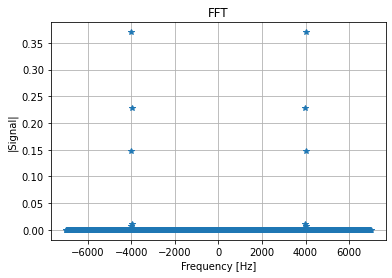

In [381]:
# Perform the FFT
y_f = fftshift(fft(y_filt,norm='forward'))
x_f = fftshift(fftfreq(N_FFT,DT))
# Plot the FFT
plt.plot((x_f),np.abs(y_f),'*')
plt.grid()
plt.title("FFT")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|Signal|")
plt.show()